In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

original_image = cv2.imread("derevo.jpg")
img = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
vectorized = img.reshape((-1, 3))
vectorized = np.float32(vectorized)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
k = 3

centers = np.random.randint(0, 256, size=(k, 3))

def evklid(x, y):
    return np.sqrt(np.sum((x - y)**2))

def k_means(data, centers, k, criteria):
    labels = np.zeros(data.shape[0], dtype=np.uint8)
    distances = np.zeros((data.shape[0], k))
    while True:
        for i in range(data.shape[0]):
            for j in range(k):
                distances[i, j] = evklid(data[i], centers[j])
            labels[i] = np.argmin(distances[i])
        new_centers = np.zeros_like(centers)
        for j in range(k):
            if np.sum(labels == j) == 0:
                new_centers[j] = centers[j]
            else:
                new_centers[j] = np.mean(data[labels == j], axis=0)
        if np.allclose(new_centers, centers):
            break
        centers = new_centers
    return labels, centers

<function matplotlib.pyplot.show(close=None, block=None)>

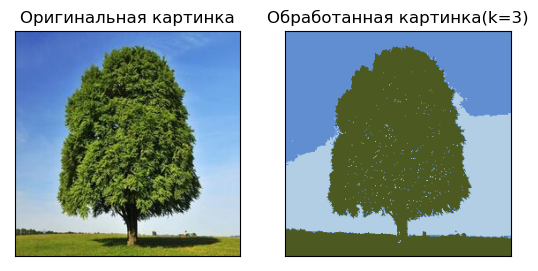

In [32]:
labels, centers = k_means(vectorized, centers, k, criteria)
centers = np.uint8(centers)
labels = labels.reshape(img.shape[0], img.shape[1])
segmented_image = centers[labels]
plt.subplot(121), plt.imshow(img), plt.title('Оригинальная картинка')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(segmented_image), plt.title(f'Обработанная картинка(k={k})')
plt.xticks([]), plt.yticks([])
plt.show

In [33]:
segmented_image.shape

(256, 256, 3)

In [34]:
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
myimage = plt.imread('derevo.jpg')


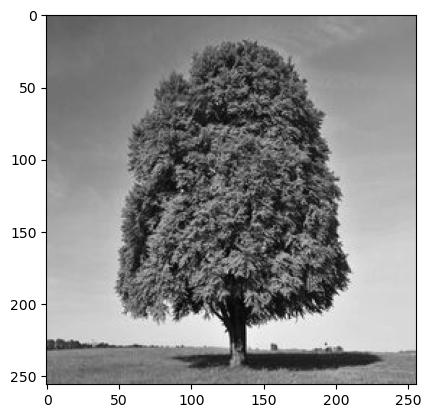

In [26]:
gray = rgb2gray(myimage)
plt.imshow(gray, cmap='gray')

In [35]:
from tensorflow.keras.preprocessing import image
x = image.img_to_array(segmented_image)

In [36]:
x = segmented_image / 255.0

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

from keras.layers.convolutional import Conv2DTranspose , Conv2D

def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(
        input_layer
    )
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    deconv4 = Conv2DTranspose(
        start_neurons * 8, (3, 3), strides=(2, 2), padding="same"
    )(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(
        uconv4
    )
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(
        uconv4
    )

    deconv3 = Conv2DTranspose(
        start_neurons * 4, (3, 3), strides=(2, 2), padding="same"
    )(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(
        uconv3
    )
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(
        uconv3
    )

    deconv2 = Conv2DTranspose(
        start_neurons * 2, (3, 3), strides=(2, 2), padding="same"
    )(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(
        uconv2
    )
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(
        uconv2
    )

    deconv1 = Conv2DTranspose(
        start_neurons * 1, (3, 3), strides=(2, 2), padding="same"
    )(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(
        uconv1
    )
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(
        uconv1
    )

    output_layer = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(uconv1)

    return output_layer


# создаем входной слой
input_layer = Input(shape=(256, 256, 3))

# создаем выходной слой с помощью функции build_model
output_layer = build_model(input_layer, start_neurons=16)

# создаем модель из входного и выходного слоев
model = Model(inputs=input_layer, outputs=output_layer)

# компилируем модель
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

input_shape = (256, 256, 3)
input_layer = Input(input_shape)

# Step 4: Build the model
start_neurons = 16
output_layer = build_model(input_layer, start_neurons)
model = Model(inputs=input_layer, outputs=output_layer)

# Step 5: Predict on the input image
x = np.expand_dims(x, axis=0)
output = model.predict(x)

# Step 6: Save the output image
output_path = 'derevo_output3.jpg'
output = np.squeeze(output, axis=0)
output = np.uint8(output * 255)
output_img = image.array_to_img(output)
output_img.save(output_path)

1/1 [==============================] - 0s 320ms/step
